In [ ]:
# data from https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!unzip '/content/drive/MyDrive/datasets/brain_tumor/dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset/images/2014.png  
  inflating: dataset/images/2015.png  
  inflating: dataset/images/2016.png  
  inflating: dataset/images/2017.png  
  inflating: dataset/images/2018.png  
  inflating: dataset/images/2019.png  
  inflating: dataset/images/202.png  
  inflating: dataset/images/2020.png  
  inflating: dataset/images/2021.png  
  inflating: dataset/images/2022.png  
  inflating: dataset/images/2023.png  
  inflating: dataset/images/2024.png  
  inflating: dataset/images/2025.png  
  inflating: dataset/images/2026.png  
  inflating: dataset/images/2027.png  
  inflating: dataset/images/2028.png  
  inflating: dataset/images/2029.png  
  inflating: dataset/images/203.png  
  inflating: dataset/images/2030.png  
  inflating: dataset/images/2031.png  
  inflating: dataset/images/2032.png  
  inflating: dataset/images/2033.png  
  inflating: dataset/images/2034.png  
  inflating: dataset/images/2035.png  
  inflating: da

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
from PIL import Image,ImageOps
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, Dropout,BatchNormalization,Conv2DTranspose,concatenate
from tensorflow.keras.models import Model,load_model
import albumentations as A

In [6]:
# for i in range(len(x_train)):
#     if x_train[i].shape != (512, 512, 3):
#         print(x_train[i].shape)

# it have some (256, 256, 3) shape
IMAGE_SIZE = 256
transform = A.Compose([
    A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE)
])

In [7]:
def loaddata(dir):
    images = []
    masks = []
    images_fol = os.path.join(dir, "images")
    masks_fol = os.path.join(dir, "masks")
    img_list = os.listdir(images_fol)
    mask_list = os.listdir(masks_fol)
    for i in tqdm(range(len(img_list)),ncols=100):
        # print(img_list[i],mask_list[i])
        image_path = os.path.join(images_fol, img_list[i])
        mask_path = os.path.join(masks_fol, mask_list[i])
        try:
            image = Image.open(image_path)
            image = ImageOps.exif_transpose(image)
            image = image.convert('RGB')
            image_array = np.array(image)
            if image_array.shape == (512, 512, 3):
                image_array = transform(image=image_array)["image"]
            mask = Image.open(mask_path)
            mask = ImageOps.exif_transpose(mask)
            mask = mask.convert('L')
            mask_array = np.array(mask)
            if mask_array.shape == (512, 512):
                mask_array = transform(image=mask_array)["image"]
            # should look dataloading sometime
            mask_array = tf.one_hot(mask_array, depth=1, dtype=tf.int32)
            images.append(image_array)
            masks.append(mask_array)
        except Exception as e:
            print(f"failed to loading {image_path,mask_path}: {e}")

    return images,masks

In [8]:
dir = "./dataset"
images,masks = loaddata("./dataset")
print(len(images),len(masks))

100%|██████████████████████████████████████████████████████████| 3064/3064 [00:19<00:00, 158.05it/s]

3064 3064


In [ ]:
print(masks[0].shape)

(256, 256, 1)


In [9]:
x_train,x_test,y_train,y_test = train_test_split(images, masks, test_size=0.2, random_state=0)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

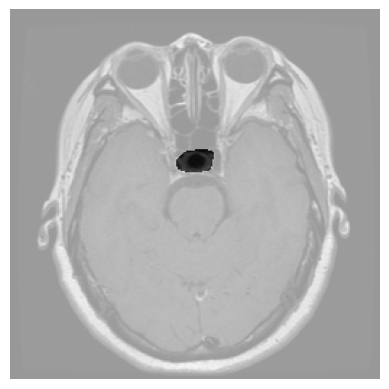

In [ ]:
fig, ax = plt.subplots()
ax.imshow(x_train[2], alpha=1.0)
ax.imshow(y_train[2],  alpha=0.6,cmap='gray')
ax.axis('off')
plt.show()

In [ ]:
# cheap unet arch
tf.keras.backend.clear_session()
model = Sequential([
    InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    # Encoder
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),

    # Bottleneck
    Conv2D(1024, (3, 3), activation='relu', padding='same'),
    Conv2D(1024, (3, 3), activation='relu', padding='same'),

    # Decoder back to same size array = (256,256,3)
    Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),

    Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),

    Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),

    Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),

    # output (256,256,1)
     Conv2D(1,(1, 1),activation='sigmoid'),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 1024)        │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 128)       │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,898,305 (106.42 MB)

 Trainable params: 27,898,305 (106.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 71s 480ms/step - accuracy: 0.9689 - loss: 0.7054 - val_accuracy: 0.9825 - val_loss: 0.0752
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9823 - loss: 0.0729 - val_accuracy: 0.9825 - val_loss: 0.0660
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9831 - loss: 0.0640 - val_accuracy: 0.9825 - val_loss: 0.0649
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9822 - loss: 0.0636 - val_accuracy: 0.9825 - val_loss: 0.0564
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9837 - loss: 0.0529 - val_accuracy: 0.9848 - val_loss: 0.0486
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.9842 - loss: 0.0507 - val_accuracy: 0.9848 - val_loss: 0.0479
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9852 - loss: 0.0454 - val_accuracy: 0.9845 - val_loss: 0.0457
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9854 - loss: 0.0432 - val_accu

In [ ]:
model.evaluate(x_test, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 206s 10s/step - accuracy: 0.9946 - loss: 0.0135


[0.014192979782819748, 0.9944395422935486]

In [12]:
model.save("model.keras")

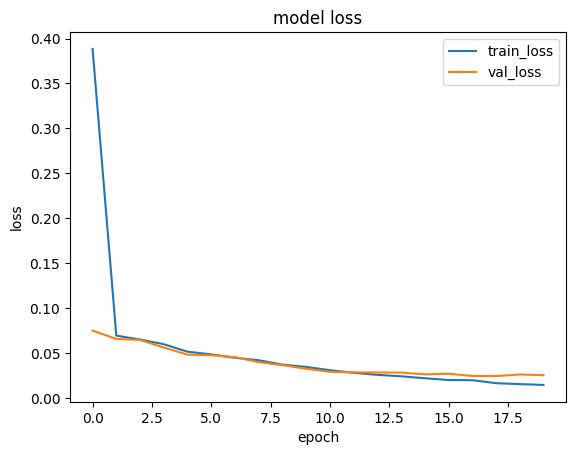

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss","val_loss"])
plt.show()

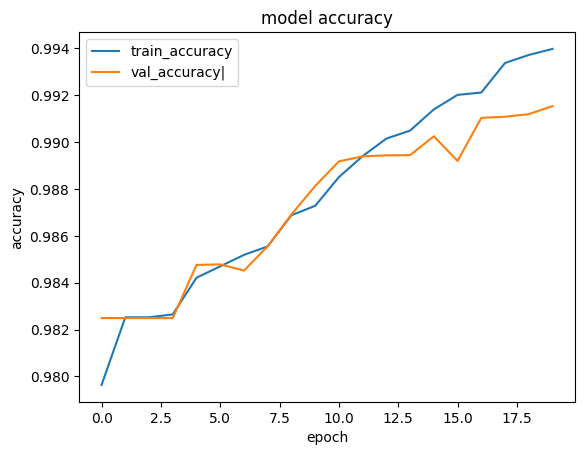

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy","val_accuracy|"])
plt.show()

In [10]:
model = load_model("model.keras")

In [ ]:
model.evaluate(x_test, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9912 - loss: 0.0277


[0.025703588500618935, 0.9915352463722229]

20/20 ━━━━━━━━━━━━━━━━━━━━ 212s 10s/step


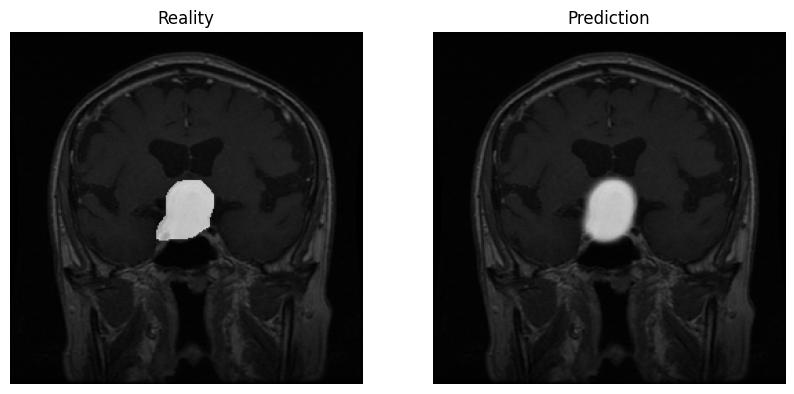

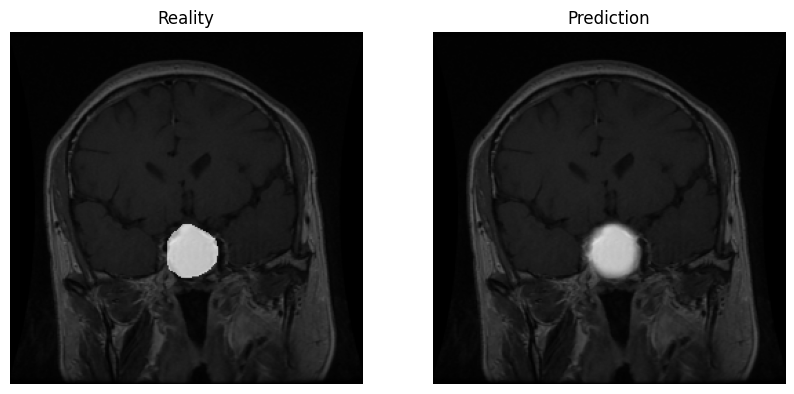

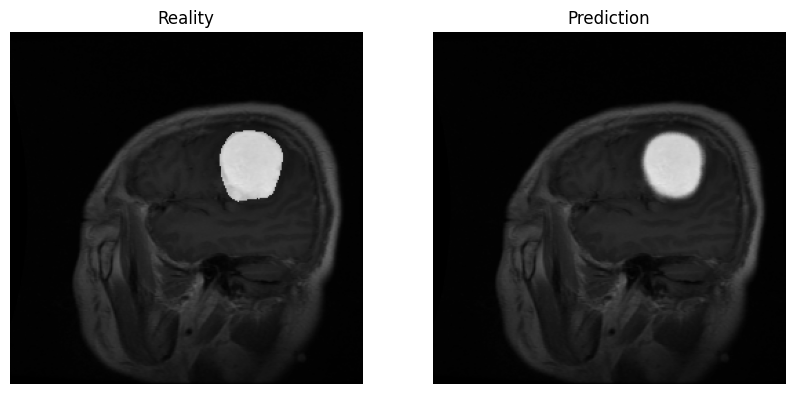

In [11]:
result = model.predict(x_test)
for index in range(3):

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('Reality')
    ax1.imshow(x_test[index], alpha=1.0)
    ax1.imshow(y_test[index], alpha=0.6, cmap='binary')
    ax1.axis('off')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.title.set_text('Prediction')
    ax2.imshow(x_test[index], alpha=1.0)
    ax2.imshow(result[index], alpha=0.6, cmap='binary')
    ax2.axis('off')
    plt.show()
